# DiffSeg Implementation Using Unet

# Import Data Extractions

In [ ]:
import os
import zipfile

**Paths to Dataset**

In [ ]:
# paths to the variables:
inpainted_zip_path = "/content/inpainted_8k_dataset.zip"
masks_zip_path = "/content/masks_8k_dataset.zip"

# Define the directories -> the place where the content will be extracted:
inpainted_dir = "/content"
masks_dir = "/content"

In [ ]:
os.makedirs(inpainted_dir, exist_ok=True)
os.makedirs(masks_dir, exist_ok=True)

In [ ]:
# Extract the Masks:
with zipfile.ZipFile(masks_zip_path, 'r') as zip_ref:
  zip_ref.extractall(masks_dir)

In [ ]:
# Extract the Inpainted Images
with zipfile.ZipFile(inpainted_zip_path, 'r') as zip_ref:
  zip_ref.extractall(inpainted_dir)


In [ ]:
num_inpainted_images = len(os.listdir(inpainted_dir))
num_masks = len(os.listdir(masks_dir))

print(f"Number of Inpainted Images: {num_inpainted_images}")
print(f"Number of Masks: {num_masks}")

Number of Inpainted Images: 7555
Number of Masks: 7563


# Custom Dataset

In [ ]:
import numpy as np
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader

**Nessecary Transformations** - *The Model is getting too overfitted so that's why this aggresive transformations are applied*

In [ ]:
# Getting the model is too overfitting

transform = A.Compose([
    #A.RandomResizedCrop(height=256, width=256, scale=(0.8, 1.0), ratio=(0.75, 1.3333333333333333), p=0.8),  # Added ratio
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=30, p=0.5),
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, p=0.5),
    A.GaussianBlur(blur_limit=(3, 7), p=0.5),

    #A.Cutout(num_holes=8, max_h_size=32, max_w_size=32, fill_value=0, p=0.5),
    A.HorizontalFlip(p=0.7),  # Increased probability
    A.VerticalFlip(p=0.7),    # Increased probability
    A.RandomRotate90(p=0.8),  # Increased probability

    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.2, rotate_limit=60, p=0.6),  # More aggressive
    A.ElasticTransform(p=0.4, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),  # Increased probability
    A.GridDistortion(p=0.4),  # Increased probability
    A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.8),  # Increased probability
    A.HueSaturationValue(p=0.4),  # Increased probability
    A.Perspective(p=0.3),

    #A.RandomCrop(height=256, width=256, always_apply=False,p=0.4),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
], is_check_shapes=False)

/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
<ipython-input-5-104b8881bb8a>:17: UserWarning: Argument(s) 'alpha_affine' are not valid for transform ElasticTransform
  A.ElasticTransform(p=0.4, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),  # Increased probability


**Create a Custom Dataset**

In [ ]:
class InpaintingDataset(Dataset):
  def __init__(self, images_dir, masks_dir, transform=None):
    self.images_dir = images_dir
    self.masks_dir = masks_dir
    self.transform = transform

    # sorting for consist ordering
    self.images = sorted(os.listdir(images_dir))

  def __len__(self):
    return len(self.images)

  def __getitem__(self, idx):
    image_name = self.images[idx]
    image_path = os.path.join(self.images_dir, image_name)

    if "_inpainted" in image_name:
      base_name = image_name.replace("_inpainted", "")

    else:
      base_name = image_name

    mask_name = base_name.replace(".jpg", "_mask.png")
    mask_path = os.path.join(self.masks_dir, mask_name)

    # load the image and mask using PIL:
    image = np.array(Image.open(image_path).convert("RGB"))
    mask = np.array(Image.open(mask_path).convert("L"))

    # Convert to a binary masks:
    mask = (mask > 127).astype(np.float32)

    # Resize images and masks to consitent size:
    image = A.Resize(512, 512)(image=image)["image"]
    mask = A.Resize(512, 512)(image=mask)["image"]

    # applying transformation to both images and masks:
    if self.transform:
      augmented = self.transform(image=image, mask=mask)
      image = augmented["image"]
      mask = augmented["mask"]

    return image, mask

In [ ]:
# Assuming you have about 7555 images total and you want to use the last 20% for validation:
all_images = sorted(os.listdir(inpainted_dir))
total_images = len(all_images)

# Calculate the No's of val Images (20%)
num_val_images = int(total_images * 0.20)

train_indices = list(range(0, total_images - num_val_images))
val_indices = list(range(total_images - num_val_images, total_images))

In [ ]:
def subset_dataset(dataset, indices):
    # Create a subset of the dataset given indices
    subset = [dataset[i] for i in indices]
    return subset

In [ ]:
# Create full dataset
full_dataset = InpaintingDataset(inpainted_dir, masks_dir, transform=transform)
print("Total samples:", len(full_dataset))

Total samples: 7555


In [ ]:
image, mask = full_dataset[0]
print(image.shape)
print(mask.shape)

torch.Size([3, 512, 512])
torch.Size([512, 512])


**Data Splitting**

In [ ]:
# Create training and validation subsets
train_data = [full_dataset[i] for i in train_indices]
val_data = [full_dataset[i] for i in val_indices]

**Data Loading**

In [ ]:
train_loader = DataLoader(
    train_data,
    batch_size = 16,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

val_loader = DataLoader(
    val_data,
    batch_size = 16,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

In [ ]:
print("Training samples:", len(train_data))
print("Validation samples:", len(val_data))

Training samples: 6044
Validation samples: 1511


# Building A Model

**Implementation of a Custom UNet Module using Pre-Trained Model**

In [ ]:
!pip install --upgrade torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 106.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 84.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 38.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 93.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitl

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

In [ ]:
# --- Convolution Blocks ----

class ConvBlock(nn.Module):
  def __init__(self, in_channels, out_channels, dropout_prob=0.0):
     super().__init__()

     self.block = nn.Sequential(
         nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
         nn.BatchNorm2d(out_channels),
         nn.ReLU(inplace=True),
         nn.Dropout2d(p=dropout_prob),
         nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
         nn.BatchNorm2d(out_channels),
         nn.ReLU(inplace=True),
         nn.Dropout2d(p=dropout_prob)
     )

  def forward(self, x):
    return self.block(x)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class UpBlock(nn.Module):
    def __init__(self, up_in_channels, skip_channels, out_channels, dropout_prob=0.0):
        super().__init__()
        # up_in_channels: number of channels from the previous decoder layer
        # skip_channels: number of channels in the skip connection
        # out_channels: number of channels after upsampling (and that you want after the conv block)

        self.up = nn.ConvTranspose2d(up_in_channels, out_channels, kernel_size=2, stride=2)

        # After upsampling, the tensor will have out_channels; concatenated with skip (skip_channels)
        self.conv = ConvBlock(out_channels + skip_channels, out_channels, dropout_prob=dropout_prob)

    def forward(self, x, skip):
        x = self.up(x)
        # Ensure the spatial dimensions match
        if x.shape[2:] != skip.shape[2:]:
            x = F.interpolate(x, size=skip.shape[2:], mode='bilinear', align_corners=False)
        # Concatenate along channel dimension
        x = torch.cat([x, skip], dim=1)
        return self.conv(x)


In [ ]:
class ResNetUNet(nn.Module):
    """
    ResNetUNet model integrating a pretrained ResNet34 encoder with a UNet decoder.
    Outputs segmentation maps.
    """
    def __init__(self, num_classes=2, dropout_prob=0.4):
        """
        Initializes the ResNetUNet model.

        Args:
            num_classes (int): The number of output classes for segmentation.
        """
        super().__init__()

        # --- Encoder (ResNet34 Backbone) ---
        # Load pretrained ResNet34
        base_model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT) # Use updated weights API
        self.base_layers = list(base_model.children())

        # Layer 0: Initial convolution and pooling
        # Input: [B, 3, H, W] (e.g., [B, 3, 512, 512])
        self.encoder1 = nn.Sequential(*self.base_layers[:3])   # Output: [B, 64, H/2, W/2] (e.g., [B, 64, 256, 256])
        self.pool1 = self.base_layers[3]                       # Output: [B, 64, H/4, W/4] (e.g., [B, 64, 128, 128])

        # ResNet Layers
        self.encoder2 = self.base_layers[4] # layer1 Output: [B, 64, H/4, W/4]  (e.g., [B, 64, 128, 128])
        self.encoder3 = self.base_layers[5] # layer2 Output: [B, 128, H/8, W/8] (e.g., [B, 128, 64, 64])
        self.encoder4 = self.base_layers[6] # layer3 Output: [B, 256, H/16, W/16](e.g., [B, 256, 32, 32])
        self.encoder5 = self.base_layers[7] # layer4 Output: [B, 512, H/32, W/32](e.g., [B, 512, 16, 16])

        # --- Bridge ---
        self.bridge = ConvBlock(512, 512) # Output: [B, 512, H/32, W/32] (e.g., [B, 512, 16, 16])

        # --- Decoder ---
        # Note: up_in_channels matches the output channels of the previous layer
        #       skip_channels matches the output channels of the corresponding encoder layer
        #       out_channels is the desired output channel count for the current decoder stage
        self.up1 = UpBlock(up_in_channels=512, skip_channels=256, out_channels=256, dropout_prob=dropout_prob) # Output: [B, 256, H/16, W/16] (e.g., [B, 256, 32, 32])
        self.up2 = UpBlock(up_in_channels=256, skip_channels=128, out_channels=128, dropout_prob=dropout_prob) # Output: [B, 128, H/8, W/8]  (e.g., [B, 128, 64, 64])
        self.up3 = UpBlock(up_in_channels=128, skip_channels=64, out_channels=64, dropout_prob=dropout_prob)   # Output: [B, 64, H/4, W/4]   (e.g., [B, 64, 128, 128])
        self.up4 = UpBlock(up_in_channels=64, skip_channels=64, out_channels=64, dropout_prob=dropout_prob)    # Output: [B, 64, H/2, W/2]   (e.g., [B, 64, 256, 256])

        # --- Final Upsampling and Output Layer ---
        # Upscale to the original input image size (or target mask size)
        self.upscale = nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2) # Output: [B, 64, H, W] (e.g., [B, 64, 512, 512])

        # Final 1x1 convolution to map features to the number of classes
        self.final = nn.Conv2d(64, num_classes, kernel_size=1) # Output: [B, num_classes, H, W] (e.g., [B, 2, 512, 512])

    def forward(self, x):
        """
        Forward pass of the ResNetUNet model.

        Args:
            x (torch.Tensor): Input tensor (image). Shape: [B, C, H, W]

        Returns:
            torch.Tensor: Output segmentation map. Shape: [B, num_classes, H, W]
        """
        # --- Encoder Path ---
        enc1 = self.encoder1(x)    # Skip connection 1: [B, 64, H/2, W/2]
        pool1 = self.pool1(enc1)
        enc2 = self.encoder2(pool1) # Skip connection 2: [B, 64, H/4, W/4]
        enc3 = self.encoder3(enc2) # Skip connection 3: [B, 128, H/8, W/8]
        enc4 = self.encoder4(enc3) # Skip connection 4: [B, 256, H/16, W/16]
        enc5 = self.encoder5(enc4) # Bottleneck features: [B, 512, H/32, W/32]

        # --- Bridge ---
        center = self.bridge(enc5) # [B, 512, H/32, W/32]

        # --- Decoder Path ---
        # Note the skip connections passed to each UpBlock
        d1 = self.up1(center, enc4) # [B, 256, H/16, W/16]
        d2 = self.up2(d1, enc3)     # [B, 128, H/8, W/8]
        d3 = self.up3(d2, enc2)     # [B, 64, H/4, W/4]
        d4 = self.up4(d3, enc1)     # [B, 64, H/2, W/2]

        # --- Final Upsampling and Output ---
        # Upscale the last decoder output to match target size
        up_out = self.upscale(d4)   # [B, 64, H, W]

        # Apply the final convolution to the upscaled output
        out = self.final(up_out)    # [B, num_classes, H, W]

        return out


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
model = ResNetUNet(num_classes=2, dropout_prob=0.2).to(device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 216MB/s]


# Creating a CombinedLoss function

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
class combinedLoss(nn.Module):
  def __init__(self, weight_ce=0.5, weight_dice=0.5):
    """
    combines CrossEntropy and DiceLoss

    Args:
      weight_ce: weight for CrossEntropyLoss
      weight_dice: weight for DiceLoss
    """

    super(combinedLoss, self).__init__()
    self.ce_loss = nn.CrossEntropyLoss()
    self.weight_ce = weight_ce
    self.weight_dice = weight_dice

  def dice_loss(self, outputs, targets, smooth=1):
    # outputs: (N, 2, H, 2); we always the probability for class is 1.

    probs = F.softmax(outputs, dim=1)[:, 1, :, :] # -> shape: (N, H, W)
    targets = targets.float() # Ensure targets are float

    # Flatten:
    probs_flat = probs.contiguous().view(probs.size(0), -1) # Changed probs(0) to probs.size(0)
    targets_flat = targets.contiguous().view(targets.size(0), -1)

    intersection = (probs_flat * targets_flat).sum(1)
    union = probs_flat.sum(1) + targets_flat.sum(1)

    dice = (2. * intersection + smooth) / (union + smooth)
    return 1 - dice.mean() # returns DiceLoss

  def forward(self, outputs, targets):

    """
      Targets expects a CrossEntropyLoss : (N, H, W), dtype: long
      Outputs expects a DiceLoss : (N, 2, H, W), dtype: float
    """

    ce = self.ce_loss(outputs, targets)
    d_loss = self.dice_loss(outputs, targets)
    return self.weight_ce * ce + self.weight_dice * d_loss

**Initilization of optimizers and Criterion**

In [ ]:
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [ ]:
criterion = combinedLoss(weight_ce=0.5, weight_dice=0.5)

# use adma with weight decay to add L2 Regulariztion:
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

# Setting up a scheduler that reduces the learning rate when validation loss plateaus...
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

# Training Config

In [ ]:
!pip install torchmetrics

In [ ]:
class EarlyStopping:

    def __init__(self, patience=5, delta=0, mode='min'):
        """
        Args:
            patience (int): Number of epochs to wait after last improvement
            delta (float): Minimum change to qualify as improvement
            mode (str): 'min' for metrics where lower is better, 'max' for higher
        """
        self.patience = patience
        self.delta = delta
        self.mode = mode
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.best_model_weights = None

    def step(self, current_score, model):
        if self.best_score is None:
            self.best_score = current_score
            self.best_model_weights = model.state_dict().copy()
        elif ((self.mode == 'min' and current_score > self.best_score + self.delta) or
              (self.mode == 'max' and current_score < self.best_score - self.delta)):
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            if (self.mode == 'min' and current_score < self.best_score) or \
               (self.mode == 'max' and current_score > self.best_score):
                self.best_score = current_score
                self.best_model_weights = model.state_dict().copy()
            self.counter = 0

        improved = (self.mode == 'min' and current_score < self.best_score - self.delta) or \
                   (self.mode == 'max' and current_score > self.best_score + self.delta)

        # reset counter if improved:
        if improved:
            self.counter = 0

        return self.early_stop, improved


# LRfinder

In [ ]:
import copy
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from tqdm.autonotebook import tqdm
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import _LRScheduler
from packaging import version
from torchvision import models
from torch.utils.data import DataLoader

In [ ]:
PYTORCH_VERSION = version.parse(torch.__version__)

In [ ]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.block(x)

# ------------------------
# Custom Up-sampling Block
# ------------------------
class UpBlock(nn.Module):
    def __init__(self, up_in_channels, skip_channels, out_channels):
        super().__init__()
        # Define upsampling with ConvTranspose2d
        self.up = nn.ConvTranspose2d(up_in_channels, out_channels, kernel_size=2, stride=2)
        # The input to ConvBlock will be concatenation of upsampled features and skip connection
        self.conv = ConvBlock(out_channels + skip_channels, out_channels)

    def forward(self, x, skip):
        x = self.up(x)
        if x.shape[2:] != skip.shape[2:]:
            x = F.interpolate(x, size=skip.shape[2:], mode='bilinear', align_corners=False)
        x = torch.cat([x, skip], dim=1)
        return self.conv(x)

In [ ]:
class ResNetUNet(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        base_model = models.resnet34(pretrained=True)
        self.base_layers = list(base_model.children())

        # Encoder: use layers from resnet34
        self.encoder1 = nn.Sequential(*self.base_layers[:3])     # conv1: [B, 64, 256,256] if input is 512x512
        self.pool1 = self.base_layers[3]                         # maxpool: [B, 64, 128,128]
        self.encoder2 = self.base_layers[4]                      # layer1: [B, 64, 128,128]
        self.encoder3 = self.base_layers[5]                      # layer2: [B, 128, 64,64]
        self.encoder4 = self.base_layers[6]                      # layer3: [B, 256, 32,32]
        self.encoder5 = self.base_layers[7]                      # layer4: [B, 512, 16,16]

        # Bridge
        self.bridge = ConvBlock(512, 512)

        # Decoder: using UpBlocks; note that you must carefully set the channels.
        # For example, we will assume:
        # - skip from encoder4 has 256 channels,
        # - skip from encoder3 has 128 channels,
        # - skip from encoder2 has 64 channels,
        # - skip from encoder1 has 64 channels.
        self.up1 = UpBlock(up_in_channels=512, skip_channels=256, out_channels=256)  # From bridge and encoder4
        self.up2 = UpBlock(up_in_channels=256, skip_channels=128, out_channels=128)  # From up1 and encoder3
        self.up3 = UpBlock(up_in_channels=128, skip_channels=64, out_channels=64)    # From up2 and encoder2
        self.up4 = UpBlock(up_in_channels=64, skip_channels=64, out_channels=64)     # From up3 and encoder1

        # Optionally, add an upscaling layer if final output resolution is smaller than desired.
        self.upscale = nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2)  # Upscale from 256x256 to 512x512

        self.final = nn.Conv2d(64, num_classes, kernel_size=1)

    def forward(self, x):
        # x: [B, 3, 512, 512]
        enc1 = self.encoder1(x)       # Expected: [B, 64, 256, 256]
        pool1 = self.pool1(enc1)      # [B, 64, 128, 128]
        enc2 = self.encoder2(pool1)   # [B, 64, 128, 128]
        enc3 = self.encoder3(enc2)    # [B, 128, 64, 64]
        enc4 = self.encoder4(enc3)    # [B, 256, 32, 32]
        enc5 = self.encoder5(enc4)    # [B, 512, 16, 16]

        bridge = self.bridge(enc5)    # [B, 512, 16, 16]

        d1 = self.up1(bridge, enc4)   # [B, 256, 32, 32]
        d2 = self.up2(d1, enc3)       # [B, 128, 64, 64]
        d3 = self.up3(d2, enc2)       # [B, 64, 128, 128]
        d4 = self.up4(d3, enc1)       # [B, 64, 256, 256]

        # Upscale to 512x512:
        d4_up = self.upscale(d4)      # [B, 64, 512, 512]
        out = self.final(d4_up)       # [B, num_classes, 512, 512]
        return out

In [ ]:
# Instantiate the model and move to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNetUNet(num_classes=2).to(device)
print("Custom U-Net built using a pre-trained ResNet34 encoder.")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 159MB/s]


Custom U-Net built using a pre-trained ResNet34 encoder.


In [ ]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 45.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 119.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 82.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 99.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstal

In [ ]:
from torchmetrics import JaccardIndex
import time

def train_and_validate(model, train_loader, val_loader, num_epochs, device, optimizer, criterion, scheduler, early_stopping=None):

    train_iou_metric = JaccardIndex(task="binary", num_classes=2).to(device)
    val_iou_metric = JaccardIndex(task="binary", num_classes=2).to(device)
    history = {'train_loss': [], 'val_loss': [], 'train_iou': [], 'val_iou': []}

    print(f"Starting training for {num_epochs} epochs on {device}")

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        start_time = time.time()
        train_iou_metric.reset()

        for images, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} (Train)"):
            images = images.to(device)
            masks = masks.long().squeeze(1).to(device)  # assuming masks shape: [B, 1, H, W]

            optimizer.zero_grad()
            outputs = model(images)  # outputs shape: [B, 2, 512, 512]
            loss = criterion(outputs, masks)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            preds = torch.argmax(outputs, dim=1)
            train_iou_metric.update(preds, masks)

        epoch_loss = running_loss / len(train_loader.dataset)
        train_iou_score = train_iou_metric.compute().item()
        history['train_loss'].append(epoch_loss)
        history['train_iou'].append(train_iou_score)

        # Validation
        model.eval()
        val_loss = 0.0
        val_iou_metric.reset()
        with torch.no_grad():
            for images, masks in tqdm(val_loader, desc="Validating"):
                images = images.to(device)
                masks_long = masks.long().squeeze(1).to(device)
                outputs = model(images)
                loss = criterion(outputs, masks_long)
                val_loss += loss.item() * images.size(0)
                preds = torch.argmax(outputs, dim=1)
                val_iou_metric.update(preds, masks_long)

        val_loss_avg = val_loss / len(val_loader.dataset)
        val_iou_score = val_iou_metric.compute().item()
        history['val_loss'].append(val_loss_avg)
        history['val_iou'].append(val_iou_score)

        elapsed = time.time() - start_time
        print(f"Epoch {epoch+1}/{num_epochs} - Time: {elapsed:.2f}s - Train Loss: {epoch_loss:.4f} - Train IoU: {train_iou_score:.4f} - Val Loss: {val_loss_avg:.4f} - Val IoU: {val_iou_score:.4f}")

        scheduler.step(val_loss_avg)
        if early_stopping is not None:
            stop, improved = early_stopping.step(val_iou_score, model)
            if improved:
                print(f"Validation IoU improved to {val_iou_score:.4f}")
            if stop:
                print(f"Early stopping triggered at epoch {epoch+1}")
                break

    print("Training Completed!")
    return history, model


In [ ]:
class StateCacher(object):
    def __init__(self, in_memory, cache_dir=None):
        self.in_memory = in_memory
        self.cache_dir = cache_dir
        if self.cache_dir is None:
            import tempfile
            self.cache_dir = tempfile.gettempdir()
        else:
            if not os.path.isdir(self.cache_dir):
                raise ValueError("Given `cache_dir` is not a valid directory.")
        self.cached = {}

    def store(self, key, state_dict):
        if self.in_memory:
            self.cached.update({key: copy.deepcopy(state_dict)})
        else:
            fn = os.path.join(self.cache_dir, "state_{}_{}.pt".format(key, id(self)))
            self.cached.update({key: fn})
            torch.save(state_dict, fn)

    def retrieve(self, key):
        if key not in self.cached:
            raise KeyError("Target {} was not cached.".format(key))
        if self.in_memory:
            return self.cached.get(key)
        else:
            fn = self.cached.get(key)
            if not os.path.exists(fn):
                raise RuntimeError("Failed to load state in {}. File doesn't exist anymore.".format(fn))
            state_dict = torch.load(fn, map_location=lambda storage, location: storage)
            return state_dict

    def __del__(self):
        if self.in_memory:
            return
        for k in self.cached:
            if os.path.exists(self.cached[k]):
                os.remove(self.cached[k])

class LinearLR(_LRScheduler):
    def __init__(self, optimizer, end_lr, num_iter, last_epoch=-1):
        self.end_lr = end_lr
        if num_iter <= 1:
            raise ValueError("`num_iter` must be larger than 1")
        self.num_iter = num_iter
        super(LinearLR, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        if PYTORCH_VERSION < version.parse("1.1.0"):
            curr_iter = self.last_epoch + 1
            r = curr_iter / (self.num_iter - 1)
        else:
            r = self.last_epoch / (self.num_iter - 1)
        return [base_lr + r * (self.end_lr - base_lr) for base_lr in self.base_lrs]

class ExponentialLR(_LRScheduler):
    def __init__(self, optimizer, end_lr, num_iter, last_epoch=-1):
        self.end_lr = end_lr
        if num_iter <= 1:
            raise ValueError("`num_iter` must be larger than 1")
        self.num_iter = num_iter
        super(ExponentialLR, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        if PYTORCH_VERSION < version.parse("1.1.0"):
            curr_iter = self.last_epoch + 1
            r = curr_iter / (self.num_iter - 1)
        else:
            r = self.last_epoch / (self.num_iter - 1)
        return [base_lr * (self.end_lr / base_lr) ** r for base_lr in self.base_lrs]

# You can add your LRFinder class here similarly if desired...


In [ ]:
# Initialize early stopper
early_stopper = EarlyStopping(
    patience=7,
    mode='max',  # Monitoring IoU (higher is better)
    delta=0.001,  # Minimum improvement threshold
)

In [ ]:
# Clearing the Cache:
torch.cuda.empty_cache()

In [ ]:
model = model.to(device)

In [ ]:
# Run training
history = train_and_validate(
    model,
    train_loader,
    val_loader,
    num_epochs=10,
    device=device,

    #early_stopping=early_stopper,

    optimizer = optimizer,
    criterion = criterion,
    scheduler = scheduler,

    #freeze_after=3
)

NameError: name 'train_loader' is not defined

# Inferencing

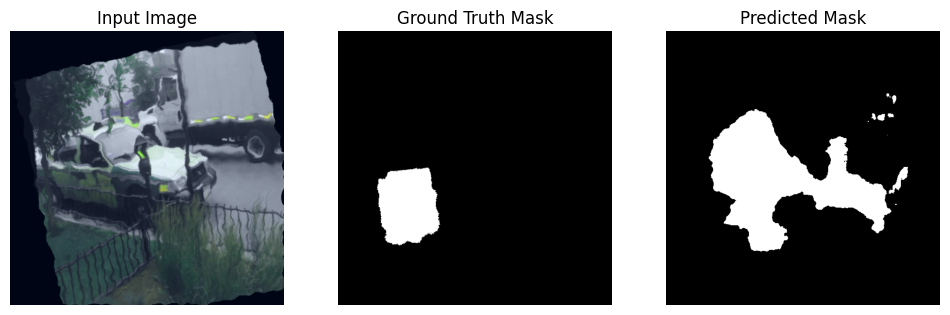

In [ ]:
import matplotlib.pyplot as plt

def visualize_sample(model, dataset, device, idx=0):
    image, gt_mask = dataset[idx]
    image_orig = image.permute(1, 2, 0).cpu().numpy()  # convert from tensor to numpy image
    image_display = (image_orig - image_orig.min()) / (image_orig.max() - image_orig.min())

    model.eval()
    with torch.no_grad():
        input_tensor = image.unsqueeze(0).to(device)
        outputs = model(input_tensor)
        preds = torch.argmax(outputs, dim=1).squeeze(0).cpu().numpy()

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(image_display)
    plt.title("Input Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(gt_mask.squeeze(0).cpu(), cmap="gray")
    plt.title("Ground Truth Mask")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(preds, cmap="gray")
    plt.title("Predicted Mask")
    plt.axis("off")
    plt.show()

# Visualize one sample from the validation set
visualize_sample(model, train_data, device, idx=0)


# Extraction of Additional Files

In [ ]:
import os
import zipfile

# Define the paths
zip_path = "/content/combined_masks.zip"
extract_dir = "/content/masks/content/dataset/masks"

# Create the extraction directory if it doesn't exist
os.makedirs(extract_dir, exist_ok=True)

# Extract the contents of the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print(f"Files extracted to {extract_dir}")

Files extracted to /content/masks/content/dataset/masks


In [ ]:
!zip -r /content/masks_8k_dataset.zip /content/masks/content/dataset/masks


Streaming output truncated to the last 5000 lines.
  adding: content/masks/content/dataset/masks/000000464089_mask.png (deflated 92%)
  adding: content/masks/content/dataset/masks/000000036172_mask.png (deflated 77%)
  adding: content/masks/content/dataset/masks/000000031322_mask.png (deflated 91%)
  adding: content/masks/content/dataset/masks/000000029282_mask.png (deflated 65%)
  adding: content/masks/content/dataset/masks/000000006161_mask.png (deflated 58%)
  adding: content/masks/content/dataset/masks/000000027911_mask.png (deflated 53%)
  adding: content/masks/content/dataset/masks/000000013288_mask.png (deflated 69%)
  adding: content/masks/content/dataset/masks/000000006128_mask.png (deflated 90%)
  adding: content/masks/content/dataset/masks/000000040453_mask.png (deflated 59%)
  adding: content/masks/content/dataset/masks/000000040990_mask.png (deflated 52%)
  adding: content/masks/content/dataset/masks/000000031800_mask.png (deflated 55%)
  adding: content/masks/content/data